# Incomplete Intros
One of the main criticisms of deep learning is that these models are “black boxes” that provide no feedback about actual features being learned. From a research perspective, this limits intuition and understanding of the effectiveness of deep models. From an engineering perspective, engineers may risk deploying models that perform well in a controlled training environment, but are actually fragile in the real world.  
In recent years, there has been many techniques developed to provide some interpretability of the parameters and performance of deep models. One popular technique is feature visualization by optimization. As Prof. Listgarten mentioned in lecture, feature visualization by optimization actually went viral in mainstream media back in 2015 under the name of “Google Deep Dream.” In short, feature visualization allows us to generate images by performing gradient ascent on an input image toward a target class (we formalize the optimization problem in a later section). These visualizations will then allow engineers/researchers to investigate whether the model has actually learned reasonable features of an object class. Below is a famous example of this technique in action from Google’s Research Blog (the same examples Prof.Listgarten showed in lecture) :

We can see that the the model has captured the “essence” of these classes pretty effectively. However, when they visualized “dumbbells” they got something unexpected. 



Observing the visualizations, we see that the model has learned that dumbbells seem to always be accompanied by a person holding/lifting them rather than just the dumbbell itself. This reveals that the model was likely only trained on dumbbells being lifted rather than dumbbells alone. This example demonstrates how one can use visualizations to catch faulty models. 
In addition, another popular techniques can Saliency maps create a visualization of the “impact” of each individual pixel on the final classification score. With the technique, engineers can visualize what parts of inputs are most important for the model.
	These techniques have been well 


# Saliency

Saliency maps are a great tool for visualizing the effect of pixels on the overall optimization of the network towards a feature. Before the softmax layer, each feature has a score prior to normalization. We can compute the gradient of a certain feature with respect to each individual pixel and coagulate the gradients together to obtain a saliency map. We take each pixel in each frame of the video and calculate its gradient of the target class with respect. Then we replace each pixel’s rgb values with the absolute value of its gradient before normalizing it. In the visualization of the saliency maps, we shade pixels brighter if they have high gradients and darker if they have low gradients. For our project, we decided to create saliency maps for videos taken from the kinetics dataset in the specified time frame provided. Instead of taking the gradient with respect to an image, we tuned the original saliency map technique (cs231) for images to video by adding another dimension to our tensor, producing moving saliency map videos. 




# Class Visualization
Starting with a random noise gif and performing gradient ascent toward a target action class, one can generate an a gif that the network will recognize as the target class. However, naively attempting this will result in adversarial images (https://blog.openai.com/adversarial-example-research/). One must employ several regaulization techniques to generate images that resemble the desired class. 

We formalize the problem in a similiar fashion as [3]. Without loss of generailty, let us consider only the RBG input. The optical flow formalization only differs from RGB in dimensions. Let $x \in R^{NxHxWxC}$ be a RGB video where $N$ is the number of frames, $H$ and $W$ are the height and width respectively, and $C$ is the number of the color channels. For the i3d model, $H=W=224$, $C=3$, and $N=25$. The number of frames can be arbitrarily long or short for visualization, but we chose 25 as that is the frame input length at test time for the i3d model. A large $N$ can result in high computation costs, while a small $N$ results in visualizations that are limited in expressing motion. 

Now, let $y$ be the target class. Let $s_y(x)$ be the logits (scores before the final softmax layer) that the i3d model assigns to the image $x$ for class $y$. Our goal we can now frame our objective as the folowing optimization problem:

$$
x^* = \arg\max_x s_y(x) - R_\theta(x)
$$

where $R_\theta$ is a paramterized regularization function that regularizes images both explicitly and implicitly. Since the regularizer function can be very complex (as described later) and no closed-form solution exists, we resort to solving this optimization problem with gradient ascent. We compute gradients of $s_y(x)$ with respect to the generated video $x$. 

Our primary explicit regualization is L2 regularization of the form 

$$
R_\theta(x) = \lambda \|x\|_2^2
$$ 

and our primary implicit regularization (as implemented in [3]) is performed by periodically blurring the generated image with a gaussian filter. These two intial regularizing operations were good enough to create baseline results, but additional operations are also used and listed below:
1. Jitter - randomly jitter pixels around between iterations
2. Scale - scale the video and then crop after $\theta$ iterations
3. Time blur - gaussian blur across frames
4. Clipping - clip pixels that fall out of a certain range

More info about class visualization is summarized very well here: https://distill.pub/2017/feature-visualization/

[2] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.

[3] Yosinski et al, "Understanding Neural Networks Through Deep Visualization", ICML 2015 Deep Learning Workshop




<img src="./experiments_rgb/arm_wrestlingclipping/arm_wrestlingclipping_rgb.gif">
<img src="./experiments_rgb/arm_wrestlingsigma_2/arm_wrestlingsigma_2_rgb.gif">

<center></center> |  <center></center>
:-------------------------:|:-------------------------:
![](./experiments_rgb/arm_wrestlingclipping/arm_wrestlingclipping_rgb.gif)  |  ![](./experiments_rgb/arm_wrestlingsigma_2/arm_wrestlingsigma_2_rgb.gif)

<table>
<tr>

<td align="center" valign="center">
<img src="./experiments_rgb/arm_wrestlingclipping/arm_wrestlingclipping_rgb.gif">
<figcaption><center>Caption goes here</center></figcaption>
</td>

<td align="center" valign="center">
<img src="./experiments_rgb/arm_wrestlingclipping/arm_wrestlingclipping_rgb.gif">
<figcaption><center>Caption text centered under the image.</center></figcaption>
</td>

</tr>
</table>

In [2]:
"""
Some setup. 
Installations are the same for the i3d model, which can be found here: https://github.com/deepmind/kinetics-i3d
Make sure i3d.py is in the same directory as this notebook.
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import imageio

# simply selects which gpu to use
# these lines may very depending on hardware
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import scipy.ndimage as nd

import i3d

In [3]:
"""
Build Joint Stream Graph (from i3d.py)
"""
_IMAGE_SIZE = 224
_NUM_CLASSES = 400

_SAMPLE_VIDEO_FRAMES = 25
_SAMPLE_PATHS = {
    'rgb': 'data/v_CricketShot_g04_c01_rgb.npy',
    'flow': 'data/v_CricketShot_g04_c01_flow.npy',
}

_CHECKPOINT_PATHS = {
    'rgb': 'data/checkpoints/rgb_scratch/model.ckpt',
    'flow': 'data/checkpoints/flow_scratch/model.ckpt',
    'rgb_imagenet': 'data/checkpoints/rgb_imagenet/model.ckpt',
    'flow_imagenet': 'data/checkpoints/flow_imagenet/model.ckpt',
}

_LABEL_MAP_PATH = 'data/label_map.txt'



imagenet_pretrained = True # use pretrained model as it had better performance
eval_type = "joint" # build the graph for both streams 
tf.reset_default_graph() # reset graph each time cell is run, prevents duplicate variables

if eval_type not in ['rgb', 'flow', 'joint']:
    raise ValueError('Bad `eval_type`, must be one of rgb, flow, joint')

kinetics_classes = [x.strip() for x in open(_LABEL_MAP_PATH)]

if eval_type in ['rgb', 'joint']:
    # RGB input has 3 channels.
    rgb_input = tf.placeholder(
        tf.float32,
        shape=(1, None, _IMAGE_SIZE, _IMAGE_SIZE, 3))
    with tf.variable_scope('RGB'):
        rgb_model = i3d.InceptionI3d(
            _NUM_CLASSES, spatial_squeeze=True, final_endpoint='Logits')
        rgb_logits, _ = rgb_model(
            rgb_input, is_training=False, dropout_keep_prob=1.0)
    rgb_variable_map = {}
    for variable in tf.global_variables():
        if variable.name.split('/')[0] == 'RGB':
            rgb_variable_map[variable.name.replace(':0', '')] = variable
    rgb_saver = tf.train.Saver(var_list=rgb_variable_map, reshape=True)

if eval_type in ['flow', 'joint']:
    # Flow input has only 2 channels.
    flow_input = tf.placeholder(
        tf.float32,
        shape=(1, None, _IMAGE_SIZE, _IMAGE_SIZE, 2))
    with tf.variable_scope('Flow'):
        flow_model = i3d.InceptionI3d(
            _NUM_CLASSES, spatial_squeeze=True, final_endpoint='Logits')
        flow_logits, _ = flow_model(
            flow_input, is_training=False, dropout_keep_prob=1.0)
    flow_variable_map = {}
    for variable in tf.global_variables():
        if variable.name.split('/')[0] == 'Flow':
            flow_variable_map[variable.name.replace(':0', '')] = variable
    flow_saver = tf.train.Saver(var_list=flow_variable_map, reshape=True)

if eval_type == 'rgb':
    model_logits = rgb_logits
elif eval_type == 'flow':
    model_logits = flow_logits
else:
    model_logits = rgb_logits + flow_logits
model_predictions = tf.nn.softmax(model_logits)

In [4]:
"""
Run sample (playing cricket) prediction with joint model
"""
eval_type = "joint"
with tf.Session() as sess:
        feed_dict = {}
        if eval_type in ['rgb', 'joint']:
            if imagenet_pretrained:
                rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb_imagenet'])
            else:
                rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb'])
            tf.logging.info('RGB checkpoint restored')
            rgb_sample = np.load(_SAMPLE_PATHS['rgb'])
            print("RGB size:", rgb_sample.shape)
            tf.logging.info('RGB data loaded, shape=%s', str(rgb_sample.shape))
            feed_dict[rgb_input] = rgb_sample

        if eval_type in ['flow', 'joint']:
            if imagenet_pretrained:
                flow_saver.restore(sess, _CHECKPOINT_PATHS['flow_imagenet'])
            else:
                flow_saver.restore(sess, _CHECKPOINT_PATHS['flow'])
            tf.logging.info('Flow checkpoint restored')
            flow_sample = np.load(_SAMPLE_PATHS['flow'])
            print("flow size:", flow_sample.shape)
            tf.logging.info('Flow data loaded, shape=%s',
                            str(flow_sample.shape))
            feed_dict[flow_input] = flow_sample
        # print("feed_dict", feed_dict)
        out_logits, out_predictions = sess.run(
            [model_logits, model_predictions],
            feed_dict=feed_dict)

        out_logits = out_logits[0]
        out_predictions = out_predictions[0]
        sorted_indices = np.argsort(out_predictions)[::-1]

        print('Norm of logits: %f' % np.linalg.norm(out_logits))
        print('\nTop classes and probabilities')
        for index in sorted_indices[:20]:
            print(out_predictions[index], out_logits[
                  index], kinetics_classes[index])

INFO:tensorflow:Restoring parameters from data/checkpoints/rgb_imagenet/model.ckpt
INFO:tensorflow:RGB checkpoint restored
RGB size: (1, 79, 224, 224, 3)
INFO:tensorflow:RGB data loaded, shape=(1, 79, 224, 224, 3)
INFO:tensorflow:Restoring parameters from data/checkpoints/flow_imagenet/model.ckpt
INFO:tensorflow:Flow checkpoint restored
flow size: (1, 79, 224, 224, 2)
INFO:tensorflow:Flow data loaded, shape=(1, 79, 224, 224, 2)
Norm of logits: 138.468658

Top classes and probabilities
1.0 41.813683 playing cricket
1.497162e-09 21.493988 hurling (sport)
3.8430797e-10 20.134106 catching or throwing baseball
1.54923e-10 19.22559 catching or throwing softball
1.1360122e-10 18.915356 hitting baseball
8.801088e-11 18.660122 playing tennis
2.441537e-11 17.377874 playing kickball
1.153184e-11 16.627773 playing squash or racquetball
6.1318776e-12 15.996162 shooting goal (soccer)
4.391727e-12 15.662385 hammer throw
2.2134183e-12 14.9772 golf putting
1.6307032e-12 14.671674 throwing discus
1.5456

In [5]:
"""
Define some helper functions
"""
from scipy.ndimage.filters import gaussian_filter1d

# blurs image
def blur_image(X, sigma=1):
    # start = time.time()
    X = gaussian_filter1d(X, sigma, axis=1)
    X = gaussian_filter1d(X, sigma, axis=2)
    X = gaussian_filter1d(X, sigma, axis=3)
    # print("Blur time", time.time()-start)
    return X

# transforms flow input into a form that can be visualize
def create_flow_image(X):
        return np.append(X + 0.5, 0.5 * np.ones((224, 224, 1)), axis=2)

# saves final video/frames and saves a .gif file
def save_gif(X, class_name, stream_type):
    # save all frames
    num_frames = X.shape[1]
    directory = "experiments_{}/{}/".format(stream_type, class_name)
    if not os.path.exists(directory):
        os.makedirs(directory)
    image_name = "{}_{}".format(class_name, stream_type)
    file_name = directory + image_name + "{}.png"
    print("file_name", file_name)
    filenames = []
    for i in range(0, num_frames):
        if stream_type == "rgb":
            plt.imshow(X[0][i])
        elif stream_type == "flow":
            plt.imshow(create_flow_image(X[0][i]))
        
        filename = file_name.format(i)
        filenames.append(filename)
        plt.savefig(filename.format(i))
    
    #create gif
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
        imageio.mimsave(directory + "/{}".format(image_name) + ".gif", images)

# returns a decreasing sigma value for gaussian blurring
def calc_sigma(curr, total, sigma):
    if curr > .75*total:
        return sigma
    
    elif curr > .5*total:
        return .75*sigma 
    
    elif curr > .25*total:
        return .5*sigma
    
    else:
        return .25*sigma
    
#crops center of video after scaling
def crop_center(img, cropx, cropy):
    y, x, channels = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)
    return img[starty:starty+cropy, startx:startx+cropx, :]

# performs scaling and cropping of video
def scale_and_crop(X, scale=1.2):
    start = time.time()
    _, frames, cropx, cropy, channels = X.shape
    for i in range(frames):
        Y = X[0][i]
        Y = nd.zoom(Y, (scale, scale, 1))
        Y = crop_center(Y, cropx, cropy)
        X[0][i] = Y


In [6]:
"""
Define our main method to create visualizations. 
The default parameters are the ones we found to produce the best results for RBG
"""
def create_class_visualization(sess, rgb_input, flow_input, target_y, logits, class_name, **kwargs):
    """
    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    - num_frames: How many frames in output 
    - stream_type: RGB stream of Optical Flow Stream
    - sigma: radius of gaussian blur filter, may decrease with number of iterations if desired
    - scale_every: How often to scale image
    - scale: ratio of scaling
    """
    print("params", kwargs)
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 1.5)
    num_iterations = kwargs.pop('num_iterations', 1000)
    blur_every = kwargs.pop('blur_every', 3)
    max_jitter = kwargs.pop('max_jitter', 32)
    show_every = kwargs.pop('show_every', 25)
    num_frames = kwargs.pop('num_frames', 25)
    stream_type = kwargs.pop('stream_type', 'rgb')
    sigma_start = kwargs.pop('sigma', 1)
    scale_every = kwargs.pop('scale_every', 250)
    scale_ratio = kwargs.pop('scale', 1.2)
    

    if stream_type == 'rgb':
        stream_input = rgb_input
        X = np.random.rand(1, 224, 224, 3) * np.ones((num_frames, 224, 224, 3))
        X = X[None]
    elif stream_type == 'flow':
        stream_input = flow_input
        X = np.random.rand(1, 224, 224, 2) * np.ones((num_frames, 224, 224, 2))
        # preprocessing flow as described in paper
        X = X - .5
        X = X[None]
        X = flow_sample
    
    loss = logits[0, target_y] # scalar loss

    grad = tf.gradients(loss, stream_input) # compute gradient
    grad = tf.squeeze(grad) - l2_reg*2*stream_input # regualarlize gradient

    start_time = time.time()
    for t in range(num_iterations):
        
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = np.random.randint(-max_jitter, max_jitter+1, 2)
        Xi = X.copy()
        X = np.roll(np.roll(X, ox, 1), oy, 2)

        # we want logits for loss
        loss = logits[0, target_y] # scalar loss

        # model.image is just the data matrix input (a gif in our case)
        gradient_step = sess.run(grad, feed_dict={stream_input:X})
        X += learning_rate * gradient_step

        # Undo the jitter
        X = np.roll(np.roll(X, -ox, 1), -oy, 2)

        # As a regularizer, clip and periodically blur
        if stream_type == 'flow':
            X = np.clip(X, -0.5, 0.5)
        elif stream_type == 'rgb':
            X = np.clip(X, 0, 1)
        
        if t % blur_every == 0 or t == num_iterations - 1:
            # sigma = calc_sigma(t, num_iterations, sigma_start) # this line allows for decreasing blurring
            X = blur_image(X, sigma=sigma_start)
        
        # scale and crop image
        if t % scale_every == 0:
            scale_and_crop(X)
        
        print("iteration:", t, time.time()-start_time)
        
        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            
            if stream_type == "rgb":
                plt.imshow(X[0][0])
            elif stream_type == "flow":
                plt.imshow(create_flow_image(X[0][0]))
          
            if t == num_iterations-1:
                save_gif(X, class_name, stream_type)
                    
            plt.title('{}_{}\nIteration {} / {}'.format(class_name, stream_type, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()
        
    return X

The cell below is used to generate RGB Visualizations. The last cell prints out mapping of all classes to ids as reference. 

Tensor("add:0", shape=(1, 400), dtype=float32)
Tensor("Placeholder:0", shape=(1, ?, 224, 224, 3), dtype=float32)
arm wrestling
INFO:tensorflow:Restoring parameters from data/checkpoints/rgb_imagenet/model.ckpt
params {'stream_type': 'rgb', 'scale_every': 200}


/home/willsong/kinetics-i3d/local/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


iteration: 0 6.03685116768


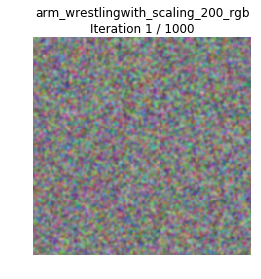

iteration: 1 6.34734201431
iteration: 2 6.55217313766
iteration: 3 6.84502601624
iteration: 4 7.06265807152
iteration: 5 7.34436607361
iteration: 6 7.77510309219
iteration: 7 8.00321912766
iteration: 8 8.25630712509
iteration: 9 8.69114518166
iteration: 10 8.91528701782
iteration: 11 9.13526821136
iteration: 12 9.44895505905
iteration: 13 9.66212821007
iteration: 14 9.88111615181
iteration: 15 10.2284591198
iteration: 16 10.449614048
iteration: 17 10.6960670948
iteration: 18 11.101703167
iteration: 19 11.3443641663
iteration: 20 11.6076171398
iteration: 21 12.0341501236
iteration: 22 12.2622241974
iteration: 23 12.4860491753
iteration: 24 12.873663187


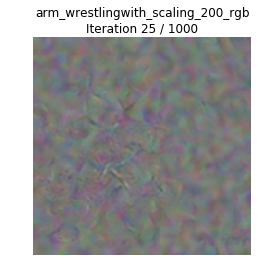

iteration: 25 13.2238140106
iteration: 26 13.4995741844
iteration: 27 13.9317262173
iteration: 28 14.1622841358
iteration: 29 14.4080240726
iteration: 30 14.7687840462
iteration: 31 14.98320508
iteration: 32 15.200412035
iteration: 33 15.5174720287
iteration: 34 15.7498512268
iteration: 35 16.035831213
iteration: 36 16.4790170193
iteration: 37 16.7093491554
iteration: 38 16.9647331238
iteration: 39 17.3939170837
iteration: 40 17.6239540577
iteration: 41 17.8734900951
iteration: 42 18.2314260006
iteration: 43 18.4519250393
iteration: 44 18.693898201
iteration: 45 19.0166070461
iteration: 46 19.2398400307
iteration: 47 19.4612491131
iteration: 48 19.846968174
iteration: 49 20.0795381069


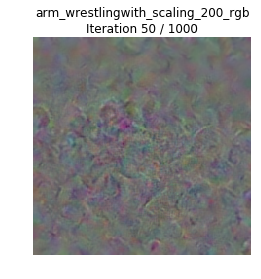

iteration: 50 20.4841351509
iteration: 51 20.8649220467
iteration: 52 21.0932941437
iteration: 53 21.3470041752
iteration: 54 21.7751810551
iteration: 55 22.0016760826
iteration: 56 22.2487571239
iteration: 57 22.6533401012
iteration: 58 22.8803670406
iteration: 59 23.1263852119
iteration: 60 23.5305891037
iteration: 61 23.7564940453
iteration: 62 23.976637125
iteration: 63 24.3361361027
iteration: 64 24.5534050465
iteration: 65 24.7730891705
iteration: 66 25.1542310715
iteration: 67 25.3777081966
iteration: 68 25.6253471375
iteration: 69 25.9734151363
iteration: 70 26.1890001297
iteration: 71 26.4090361595
iteration: 72 26.7638339996
iteration: 73 26.9826831818
iteration: 74 27.2285721302


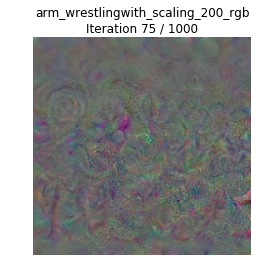

iteration: 75 27.7269761562
iteration: 76 27.9571101665
iteration: 77 28.2325220108
iteration: 78 28.5446591377
iteration: 79 28.7630882263
iteration: 80 29.0046200752
iteration: 81 29.31620121
iteration: 82 29.5314919949
iteration: 83 29.7501130104
iteration: 84 30.1035079956
iteration: 85 30.3269212246
iteration: 86 30.5622861385
iteration: 87 30.9151690006
iteration: 88 31.1390640736
iteration: 89 31.3598291874
iteration: 90 31.7145431042
iteration: 91 31.9363801479
iteration: 92 32.1785290241
iteration: 93 32.5751690865
iteration: 94 32.8062551022
iteration: 95 33.0541260242
iteration: 96 33.4453279972
iteration: 97 33.6786570549
iteration: 98 33.9489941597
iteration: 99 34.2588071823


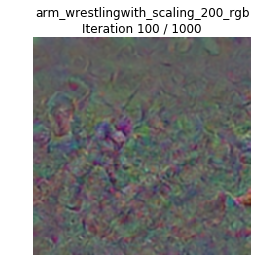

iteration: 100 34.5857360363
iteration: 101 34.805011034
iteration: 102 35.1202540398
iteration: 103 35.3390100002
iteration: 104 35.5715382099
iteration: 105 35.8826110363
iteration: 106 36.1007590294
iteration: 107 36.3177552223
iteration: 108 36.6301350594
iteration: 109 36.8419761658
iteration: 110 37.0533111095
iteration: 111 37.3545181751
iteration: 112 37.5658872128
iteration: 113 37.7975170612
iteration: 114 38.0981349945
iteration: 115 38.3024990559
iteration: 116 38.5097191334
iteration: 117 38.8385980129
iteration: 118 39.0562121868
iteration: 119 39.297465086
iteration: 120 39.6972680092
iteration: 121 39.9228641987
iteration: 122 40.1458230019
iteration: 123 40.505215168
iteration: 124 40.7299220562


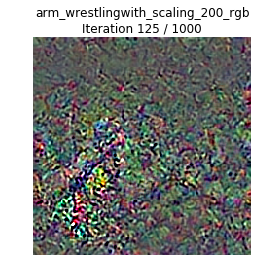

iteration: 125 41.0725400448
iteration: 126 41.451305151
iteration: 127 41.6881091595
iteration: 128 41.945068121
iteration: 129 42.3375461102
iteration: 130 42.5699381828
iteration: 131 42.8321590424
iteration: 132 43.2560682297
iteration: 133 43.4857721329
iteration: 134 43.7317960262
iteration: 135 44.1004052162
iteration: 136 44.323431015
iteration: 137 44.55768013
iteration: 138 44.998470068
iteration: 139 45.2391459942
iteration: 140 45.5221991539
iteration: 141 45.9587540627
iteration: 142 46.1983180046
iteration: 143 46.4563400745
iteration: 144 46.8509762287
iteration: 145 47.0752701759
iteration: 146 47.2990670204
iteration: 147 47.6538472176
iteration: 148 47.8878030777
iteration: 149 48.1770701408


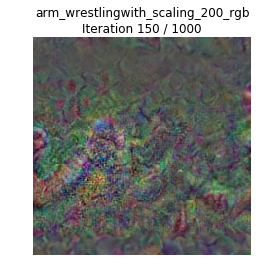

iteration: 150 48.7115120888
iteration: 151 48.9698870182
iteration: 152 49.2545061111
iteration: 153 49.6358551979
iteration: 154 49.8648052216
iteration: 155 50.1142921448
iteration: 156 50.4403381348
iteration: 157 50.6676721573
iteration: 158 50.9016082287
iteration: 159 51.2431402206
iteration: 160 51.4764330387
iteration: 161 51.7632541656
iteration: 162 52.1884670258
iteration: 163 52.4197502136
iteration: 164 52.6823980808
iteration: 165 53.1072461605
iteration: 166 53.3385560513
iteration: 167 53.5965101719
iteration: 168 54.0064201355
iteration: 169 54.2277491093
iteration: 170 54.4512741566
iteration: 171 54.792525053
iteration: 172 55.0232350826
iteration: 173 55.2593851089
iteration: 174 55.6280071735


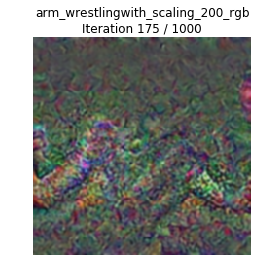

iteration: 175 55.9560132027
iteration: 176 56.1813161373
iteration: 177 56.5172891617
iteration: 178 56.7324101925
iteration: 179 56.9774720669
iteration: 180 57.322589159
iteration: 181 57.5491440296
iteration: 182 57.8058540821
iteration: 183 58.1513850689
iteration: 184 58.3785271645
iteration: 185 58.6223862171
iteration: 186 58.9549951553
iteration: 187 59.1774010658
iteration: 188 59.4268569946
iteration: 189 59.7956562042
iteration: 190 60.0236241817
iteration: 191 60.2732450962
iteration: 192 60.6463081837
iteration: 193 60.8686010838
iteration: 194 61.0916781425
iteration: 195 61.4375522137
iteration: 196 61.6594700813
iteration: 197 61.891187191
iteration: 198 62.2697541714
iteration: 199 62.502076149


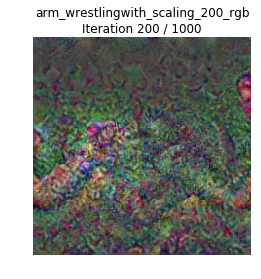

iteration: 200 65.5477750301
iteration: 201 65.8873991966
iteration: 202 66.1157150269
iteration: 203 66.490470171
iteration: 204 66.8580570221
iteration: 205 67.0895850658
iteration: 206 67.3397870064
iteration: 207 67.6631920338
iteration: 208 67.8906421661
iteration: 209 68.1384871006
iteration: 210 68.5285651684
iteration: 211 68.7614500523
iteration: 212 69.0215830803
iteration: 213 69.4274032116
iteration: 214 69.6624670029
iteration: 215 69.9168870449
iteration: 216 70.3229620457
iteration: 217 70.5530581474
iteration: 218 70.785474062
iteration: 219 71.1814651489
iteration: 220 71.4218020439
iteration: 221 71.6707491875
iteration: 222 72.0193901062
iteration: 223 72.2497401237
iteration: 224 72.5161201954


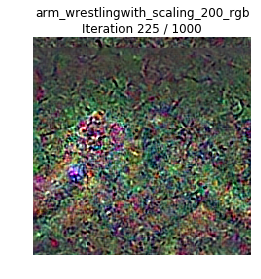

iteration: 225 73.0371119976
iteration: 226 73.2707891464
iteration: 227 73.542910099
iteration: 228 73.9891600609
iteration: 229 74.2259600163
iteration: 230 74.4892590046
iteration: 231 74.8937401772
iteration: 232 75.1337170601
iteration: 233 75.4006271362
iteration: 234 75.8538091183
iteration: 235 76.0979912281
iteration: 236 76.3606982231
iteration: 237 76.7913181782
iteration: 238 77.0403490067
iteration: 239 77.3010730743
iteration: 240 77.6709070206
iteration: 241 77.8978171349
iteration: 242 78.1369140148
iteration: 243 78.5828561783
iteration: 244 78.8291811943
iteration: 245 79.1209290028
iteration: 246 79.5356571674
iteration: 247 79.771105051
iteration: 248 80.0265371799
iteration: 249 80.4554400444


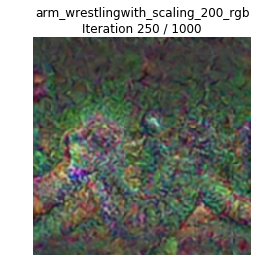

iteration: 250 80.8810369968
iteration: 251 81.182749033
iteration: 252 81.6212601662
iteration: 253 81.8675861359
iteration: 254 82.1607980728
iteration: 255 82.6124711037
iteration: 256 82.8568789959
iteration: 257 83.1363580227
iteration: 258 83.5627291203
iteration: 259 83.798320055
iteration: 260 84.0672340393
iteration: 261 84.5151062012
iteration: 262 84.7636380196
iteration: 263 85.0659019947
iteration: 264 85.5166079998
iteration: 265 85.7491931915
iteration: 266 86.0053110123
iteration: 267 86.4594922066
iteration: 268 86.7075622082
iteration: 269 86.9719049931
iteration: 270 87.4090571404
iteration: 271 87.6583590508
iteration: 272 87.9573910236
iteration: 273 88.3658061028
iteration: 274 88.5986180305


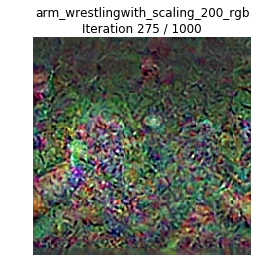

iteration: 275 88.9353041649
iteration: 276 89.3244671822
iteration: 277 89.5625882149
iteration: 278 89.8498802185
iteration: 279 90.2885351181
iteration: 280 90.5348291397
iteration: 281 90.8297231197
iteration: 282 91.2632861137
iteration: 283 91.5031480789
iteration: 284 91.7602062225
iteration: 285 92.1928341389
iteration: 286 92.436989069
iteration: 287 92.6999671459
iteration: 288 93.0711271763
iteration: 289 93.303768158
iteration: 290 93.5409290791
iteration: 291 93.9290790558
iteration: 292 94.1632740498
iteration: 293 94.4305691719
iteration: 294 94.8952300549
iteration: 295 95.1435651779
iteration: 296 95.4103941917
iteration: 297 95.8385431767
iteration: 298 96.0740461349
iteration: 299 96.3314142227


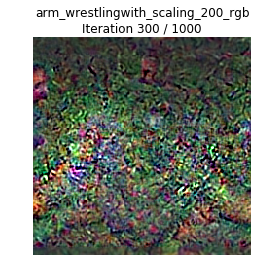

iteration: 300 96.876335144
iteration: 301 97.1226611137
iteration: 302 97.3921451569
iteration: 303 97.7617890835
iteration: 304 97.9974300861
iteration: 305 98.2426121235
iteration: 306 98.652657032
iteration: 307 98.8808240891
iteration: 308 99.1242630482
iteration: 309 99.5299520493
iteration: 310 99.7703030109
iteration: 311 100.038555145
iteration: 312 100.397908211
iteration: 313 100.632546186
iteration: 314 100.898899078
iteration: 315 101.292953014
iteration: 316 101.527685165
iteration: 317 101.767088175
iteration: 318 102.09732604
iteration: 319 102.333499193
iteration: 320 102.597588062
iteration: 321 102.9640522
iteration: 322 103.204169035
iteration: 323 103.459996223
iteration: 324 103.861996174


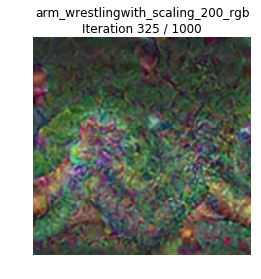

iteration: 325 104.198974133
iteration: 326 104.431776047
iteration: 327 104.798197031
iteration: 328 105.030218124
iteration: 329 105.273244143
iteration: 330 105.608974218
iteration: 331 105.837284088
iteration: 332 106.066419125
iteration: 333 106.423046112
iteration: 334 106.662188053
iteration: 335 106.909619093
iteration: 336 107.31521821
iteration: 337 107.550676107
iteration: 338 107.811438084
iteration: 339 108.217940092
iteration: 340 108.46126008
iteration: 341 108.732689142
iteration: 342 109.11328721
iteration: 343 109.349385023
iteration: 344 109.622180223
iteration: 345 110.066707134
iteration: 346 110.308355093
iteration: 347 110.573978186
iteration: 348 110.952732086
iteration: 349 111.175903082


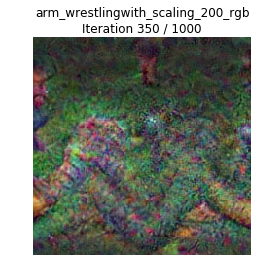

iteration: 350 111.508968115
iteration: 351 111.9579041
iteration: 352 112.192399025
iteration: 353 112.447672129
iteration: 354 112.762108088
iteration: 355 112.983348131
iteration: 356 113.225502014
iteration: 357 113.612068176
iteration: 358 113.847970009
iteration: 359 114.092379093
iteration: 360 114.434442043
iteration: 361 114.672703028
iteration: 362 114.930186033
iteration: 363 115.350845098
iteration: 364 115.582825184
iteration: 365 115.833037138
iteration: 366 116.298091173
iteration: 367 116.561011076
iteration: 368 116.858008146
iteration: 369 117.282762051
iteration: 370 117.530918121
iteration: 371 117.789835215
iteration: 372 118.211818218
iteration: 373 118.467481136
iteration: 374 118.770929098


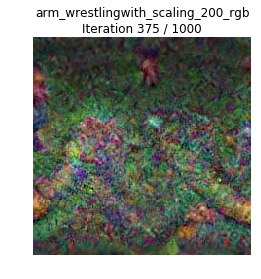

iteration: 375 119.279453993
iteration: 376 119.535316229
iteration: 377 119.81193614
iteration: 378 120.261957169
iteration: 379 120.505187035
iteration: 380 120.760670185
iteration: 381 121.152915001
iteration: 382 121.39276123
iteration: 383 121.649059057
iteration: 384 122.006008148
iteration: 385 122.248680115
iteration: 386 122.492122173
iteration: 387 122.838539124
iteration: 388 123.076930046
iteration: 389 123.347864151
iteration: 390 123.806188107
iteration: 391 124.059641123
iteration: 392 124.328529119
iteration: 393 124.725038052
iteration: 394 124.966035128
iteration: 395 125.236914158
iteration: 396 125.690131187
iteration: 397 125.936718225
iteration: 398 126.2079072
iteration: 399 126.619277


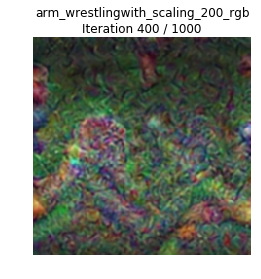

iteration: 400 129.680256128
iteration: 401 129.908367157
iteration: 402 130.282903194
iteration: 403 130.52316308
iteration: 404 130.783505201
iteration: 405 131.183822155
iteration: 406 131.42524004
iteration: 407 131.682079077
iteration: 408 132.077069044
iteration: 409 132.318249226
iteration: 410 132.572399139
iteration: 411 132.967379093
iteration: 412 133.214131117
iteration: 413 133.468366146
iteration: 414 133.796085119
iteration: 415 134.036013126
iteration: 416 134.303164005
iteration: 417 134.658631086
iteration: 418 134.906555176
iteration: 419 135.19730711
iteration: 420 135.567389011
iteration: 421 135.807215214
iteration: 422 136.059428215
iteration: 423 136.516207218
iteration: 424 136.763485193


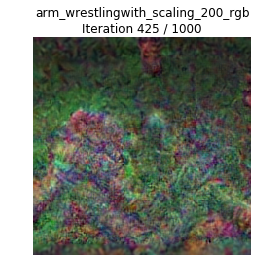

iteration: 425 137.134554148
iteration: 426 137.494003057
iteration: 427 137.739738226
iteration: 428 138.002378225
iteration: 429 138.435065031
iteration: 430 138.679458141
iteration: 431 138.947445154
iteration: 432 139.386678219
iteration: 433 139.635464191
iteration: 434 139.910050154
iteration: 435 140.351477146
iteration: 436 140.599938154
iteration: 437 140.853924036
iteration: 438 141.288016081
iteration: 439 141.538110018
iteration: 440 141.777191162
iteration: 441 142.163257122
iteration: 442 142.400687218
iteration: 443 142.639334202
iteration: 444 143.0326612
iteration: 445 143.275587082
iteration: 446 143.540706158
iteration: 447 143.950550079
iteration: 448 144.19435811
iteration: 449 144.459010124


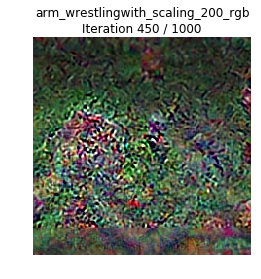

iteration: 450 144.894084215
iteration: 451 145.133350134
iteration: 452 145.391349077
iteration: 453 145.718116999
iteration: 454 145.957848072
iteration: 455 146.223999023
iteration: 456 146.649542093
iteration: 457 146.904903173
iteration: 458 147.206844091
iteration: 459 147.63203311
iteration: 460 147.889631033
iteration: 461 148.20292902
iteration: 462 148.639671087
iteration: 463 148.894883156
iteration: 464 149.161343098
iteration: 465 149.567746162
iteration: 466 149.815337181
iteration: 467 150.089781046
iteration: 468 150.470090151
iteration: 469 150.724500179
iteration: 470 151.040851116
iteration: 471 151.485591173
iteration: 472 151.746877193
iteration: 473 152.050240993
iteration: 474 152.490157127


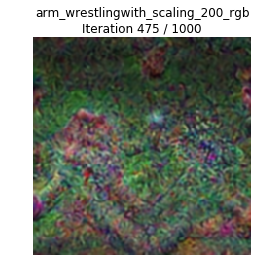

iteration: 475 152.842272043
iteration: 476 153.119841099
iteration: 477 153.564435005
iteration: 478 153.812381029
iteration: 479 154.081740141
iteration: 480 154.496017218
iteration: 481 154.759737015
iteration: 482 155.069912195
iteration: 483 155.502309084
iteration: 484 155.761437178
iteration: 485 156.04084301
iteration: 486 156.460628033
iteration: 487 156.715880156
iteration: 488 156.985417128
iteration: 489 157.419085026
iteration: 490 157.670280218
iteration: 491 157.949800014
iteration: 492 158.397456169
iteration: 493 158.650291204
iteration: 494 158.895678997
iteration: 495 159.284176111
iteration: 496 159.528100014
iteration: 497 159.796891212
iteration: 498 160.194995165
iteration: 499 160.446741104


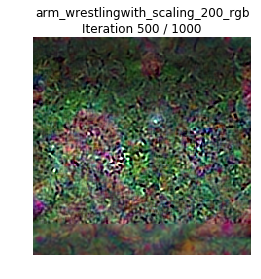

iteration: 500 160.889458179
iteration: 501 161.339145184
iteration: 502 161.590505123
iteration: 503 161.868482113
iteration: 504 162.286138058
iteration: 505 162.527879
iteration: 506 162.773360014
iteration: 507 163.120514154
iteration: 508 163.404655218
iteration: 509 163.663869143
iteration: 510 164.086989164
iteration: 511 164.338744164
iteration: 512 164.588920116
iteration: 513 164.972256184
iteration: 514 165.216163158
iteration: 515 165.476391077
iteration: 516 165.906974077
iteration: 517 166.160191059
iteration: 518 166.440664053
iteration: 519 166.887215137
iteration: 520 167.132610083
iteration: 521 167.375661135
iteration: 522 167.767287016
iteration: 523 168.021504164
iteration: 524 168.321202993


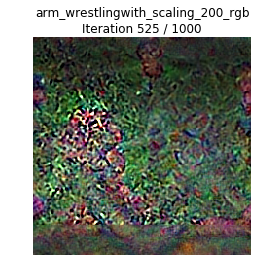

iteration: 525 168.940253019
iteration: 526 169.186219215
iteration: 527 169.428484201
iteration: 528 169.79914403
iteration: 529 170.046450138
iteration: 530 170.29580307
iteration: 531 170.756465197
iteration: 532 171.025795221
iteration: 533 171.339044094
iteration: 534 171.778084993
iteration: 535 172.062833071
iteration: 536 172.335368156
iteration: 537 172.740797997
iteration: 538 172.990364075
iteration: 539 173.265008211
iteration: 540 173.683502197
iteration: 541 173.934182167
iteration: 542 174.198032141
iteration: 543 174.592829227
iteration: 544 174.844575167
iteration: 545 175.127705097
iteration: 546 175.589774132
iteration: 547 175.857455015
iteration: 548 176.163487196
iteration: 549 176.600615025


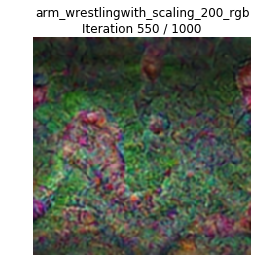

iteration: 550 176.997574091
iteration: 551 177.289372206
iteration: 552 177.659137011
iteration: 553 177.909914017
iteration: 554 178.176078081
iteration: 555 178.579653025
iteration: 556 178.848610163
iteration: 557 179.169880152
iteration: 558 179.605064154
iteration: 559 179.855159044
iteration: 560 180.10922718
iteration: 561 180.464137077
iteration: 562 180.720615149
iteration: 563 181.038091183
iteration: 564 181.458498001
iteration: 565 181.713799
iteration: 566 181.99120903
iteration: 567 182.353049994
iteration: 568 182.589673042
iteration: 569 182.848905087
iteration: 570 183.246679068
iteration: 571 183.490303993
iteration: 572 183.7349751
iteration: 573 184.133006096
iteration: 574 184.379830122


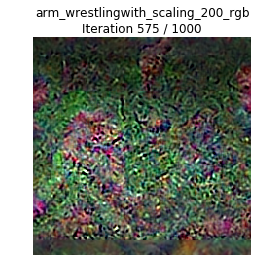

iteration: 575 184.736109018
iteration: 576 185.071816206
iteration: 577 185.322801113
iteration: 578 185.601293087
iteration: 579 186.063118219
iteration: 580 186.330713034
iteration: 581 186.649341106
iteration: 582 187.12224412
iteration: 583 187.396546125
iteration: 584 187.70985508
iteration: 585 188.133409023
iteration: 586 188.39331913
iteration: 587 188.683008194
iteration: 588 189.148073196
iteration: 589 189.411511183
iteration: 590 189.693253994
iteration: 591 190.160659075
iteration: 592 190.415243149
iteration: 593 190.675046206
iteration: 594 191.025988102
iteration: 595 191.282540083
iteration: 596 191.596302032
iteration: 597 192.04540205
iteration: 598 192.313383102
iteration: 599 192.632501125


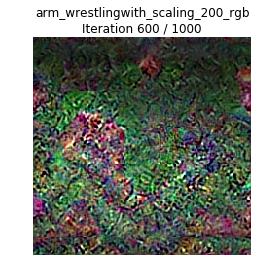

iteration: 600 195.830904007
iteration: 601 196.073955059
iteration: 602 196.344194174
iteration: 603 196.79344821
iteration: 604 197.049351215
iteration: 605 197.338771105
iteration: 606 197.743620157
iteration: 607 197.999834061
iteration: 608 198.275243044
iteration: 609 198.723365068
iteration: 610 198.98835206
iteration: 611 199.300954103
iteration: 612 199.753548145
iteration: 613 200.013207197
iteration: 614 200.297498226
iteration: 615 200.647269011
iteration: 616 200.903966188
iteration: 617 201.207182169
iteration: 618 201.644101143
iteration: 619 201.902582169
iteration: 620 202.214379072
iteration: 621 202.670921087
iteration: 622 202.926281214
iteration: 623 203.212931156
iteration: 624 203.672938108


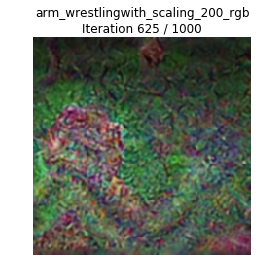

iteration: 625 204.042801142
iteration: 626 204.35634923
iteration: 627 204.81340003
iteration: 628 205.081479073
iteration: 629 205.402401209
iteration: 630 205.836998224
iteration: 631 206.095122099
iteration: 632 206.377450228
iteration: 633 206.78124404
iteration: 634 207.041676998
iteration: 635 207.317064047
iteration: 636 207.727320194
iteration: 637 207.980822086
iteration: 638 208.256680012
iteration: 639 208.671865225
iteration: 640 208.924363136
iteration: 641 209.201273203
iteration: 642 209.60703516
iteration: 643 209.861612082
iteration: 644 210.138747215
iteration: 645 210.555377007
iteration: 646 210.807918072
iteration: 647 211.087215185
iteration: 648 211.516708136
iteration: 649 211.775494099


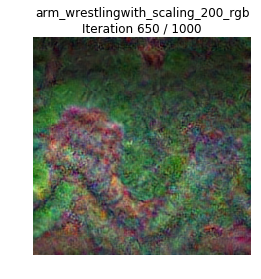

iteration: 650 212.159783125
iteration: 651 212.578096151
iteration: 652 212.833968163
iteration: 653 213.141140223
iteration: 654 213.559261084
iteration: 655 213.818554163
iteration: 656 214.098097086
iteration: 657 214.559237003
iteration: 658 214.826313019
iteration: 659 215.154528141
iteration: 660 215.617182016
iteration: 661 215.890269041
iteration: 662 216.190213203
iteration: 663 216.653154135
iteration: 664 216.90963316
iteration: 665 217.18001318
iteration: 666 217.593492031
iteration: 667 217.858945131
iteration: 668 218.18070817
iteration: 669 218.611937046
iteration: 670 218.871800184
iteration: 671 219.155340195
iteration: 672 219.612024069
iteration: 673 219.875169039
iteration: 674 220.171392202


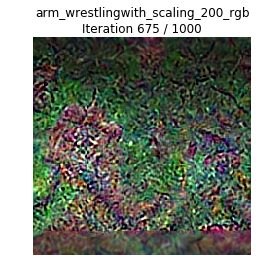

iteration: 675 220.804182053
iteration: 676 221.065177202
iteration: 677 221.343243122
iteration: 678 221.793366194
iteration: 679 222.054834127
iteration: 680 222.335587025
iteration: 681 222.754557133
iteration: 682 223.009376049
iteration: 683 223.288619041
iteration: 684 223.706446171
iteration: 685 223.970854998
iteration: 686 224.276214123
iteration: 687 224.647377014
iteration: 688 224.902152061
iteration: 689 225.158203125
iteration: 690 225.519817114
iteration: 691 225.775029182
iteration: 692 226.043629169
iteration: 693 226.425821066
iteration: 694 226.689182997
iteration: 695 226.993323088
iteration: 696 227.355473995
iteration: 697 227.606554031
iteration: 698 227.866793156
iteration: 699 228.244145155


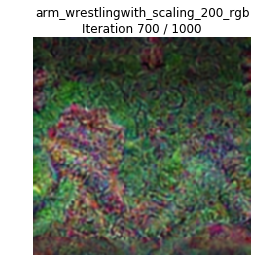

iteration: 700 228.60030818
iteration: 701 228.881470203
iteration: 702 229.291452169
iteration: 703 229.549841166
iteration: 704 229.849445105
iteration: 705 230.319172144
iteration: 706 230.589230061
iteration: 707 230.910214186
iteration: 708 231.338819027
iteration: 709 231.60939312
iteration: 710 231.927854061
iteration: 711 232.378260136
iteration: 712 232.638968229
iteration: 713 232.920305014
iteration: 714 233.36158514
iteration: 715 233.627167225
iteration: 716 233.906751156
iteration: 717 234.362082005
iteration: 718 234.625671148
iteration: 719 234.918024063
iteration: 720 235.372214079
iteration: 721 235.643903017
iteration: 722 235.976908207
iteration: 723 236.413926125
iteration: 724 236.675051212


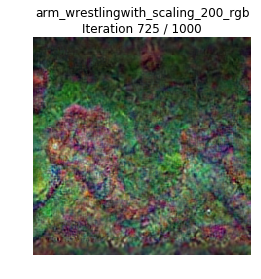

iteration: 725 237.058703184
iteration: 726 237.471442223
iteration: 727 237.732616186
iteration: 728 238.010735035
iteration: 729 238.462456226
iteration: 730 238.730836153
iteration: 731 239.030501127
iteration: 732 239.45333004
iteration: 733 239.717190027
iteration: 734 240.005017042
iteration: 735 240.424025059
iteration: 736 240.692900181
iteration: 737 240.977968216
iteration: 738 241.444248199
iteration: 739 241.706003189
iteration: 740 241.979614019
iteration: 741 242.407490015
iteration: 742 242.676444054
iteration: 743 242.959924221
iteration: 744 243.383221149
iteration: 745 243.660383224
iteration: 746 243.977263212
iteration: 747 244.412533045
iteration: 748 244.683524132
iteration: 749 244.991960049


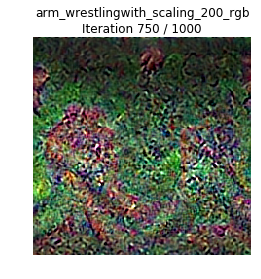

iteration: 750 245.580044031
iteration: 751 245.857364178
iteration: 752 246.176289082
iteration: 753 246.799081087
iteration: 754 247.068359137
iteration: 755 247.349098206
iteration: 756 247.772648096
iteration: 757 248.040113211
iteration: 758 248.340773106
iteration: 759 248.769877195
iteration: 760 249.044078112
iteration: 761 249.343399048
iteration: 762 249.807268143
iteration: 763 250.08792901
iteration: 764 250.407501221
iteration: 765 250.856499195
iteration: 766 251.128350019
iteration: 767 251.407840014
iteration: 768 251.777469158
iteration: 769 252.035988092
iteration: 770 252.302761078
iteration: 771 252.690457106
iteration: 772 252.955313206
iteration: 773 253.23399806
iteration: 774 253.647123098


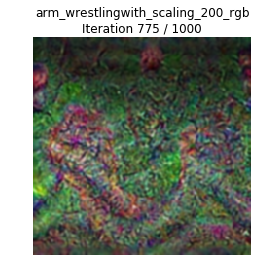

iteration: 775 254.07683301
iteration: 776 254.401575089
iteration: 777 254.843804121
iteration: 778 255.103863001
iteration: 779 255.366620064
iteration: 780 255.748831034
iteration: 781 256.022380114
iteration: 782 256.340586185
iteration: 783 256.800679207
iteration: 784 257.076520205
iteration: 785 257.385023117
iteration: 786 257.74207902
iteration: 787 258.010752201
iteration: 788 258.287584066
iteration: 789 258.775572062
iteration: 790 259.047007084
iteration: 791 259.337509155
iteration: 792 259.796153069
iteration: 793 260.07902503
iteration: 794 260.417580128
iteration: 795 260.908900023
iteration: 796 261.179655075
iteration: 797 261.480254173
iteration: 798 261.977011204
iteration: 799 262.251308203


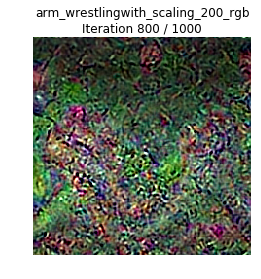

iteration: 800 265.386014223
iteration: 801 265.807168007
iteration: 802 266.074744225
iteration: 803 266.368357182
iteration: 804 266.868429184
iteration: 805 267.164330006
iteration: 806 267.485920191
iteration: 807 267.939520121
iteration: 808 268.217452049
iteration: 809 268.548376083
iteration: 810 268.992937088
iteration: 811 269.25760603
iteration: 812 269.537427187
iteration: 813 270.032555103
iteration: 814 270.30686307
iteration: 815 270.59613204
iteration: 816 271.00922513
iteration: 817 271.277244091
iteration: 818 271.566024065
iteration: 819 271.96185708
iteration: 820 272.240809202
iteration: 821 272.534723043
iteration: 822 272.961951017
iteration: 823 273.240829229
iteration: 824 273.536763191


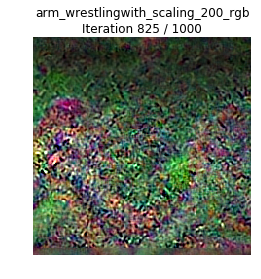

iteration: 825 274.09922123
iteration: 826 274.379113197
iteration: 827 274.699584007
iteration: 828 275.115200043
iteration: 829 275.381341219
iteration: 830 275.6782341
iteration: 831 276.163662195
iteration: 832 276.436728001
iteration: 833 276.722807169
iteration: 834 277.172281027
iteration: 835 277.459286213
iteration: 836 277.794035196
iteration: 837 278.282362223
iteration: 838 278.565680027
iteration: 839 278.890947104
iteration: 840 279.354115009
iteration: 841 279.640483141
iteration: 842 279.970102072
iteration: 843 280.440504074
iteration: 844 280.716128111
iteration: 845 280.997794151
iteration: 846 281.420385122
iteration: 847 281.688225031
iteration: 848 281.980904102
iteration: 849 282.397618055


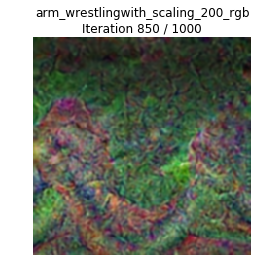

iteration: 850 282.771195173
iteration: 851 283.039342165
iteration: 852 283.467927217
iteration: 853 283.746611118
iteration: 854 284.080693007
iteration: 855 284.508105993
iteration: 856 284.772874117
iteration: 857 285.071943045
iteration: 858 285.535389185
iteration: 859 285.807174206
iteration: 860 286.106361151
iteration: 861 286.598458052
iteration: 862 286.875374079
iteration: 863 287.177594185
iteration: 864 287.640230179
iteration: 865 287.914837122
iteration: 866 288.209926128
iteration: 867 288.639678001
iteration: 868 288.906944036
iteration: 869 289.197197199
iteration: 870 289.673257113
iteration: 871 289.946013212
iteration: 872 290.229815006
iteration: 873 290.689571142
iteration: 874 290.96521306


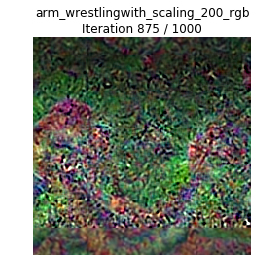

iteration: 875 291.357844114
iteration: 876 291.791785002
iteration: 877 292.068699121
iteration: 878 292.397305012
iteration: 879 292.83059907
iteration: 880 293.11009717
iteration: 881 293.444717169
iteration: 882 293.877080202
iteration: 883 294.148782015
iteration: 884 294.425402164
iteration: 885 294.895644188
iteration: 886 295.181208134
iteration: 887 295.51208806
iteration: 888 295.959840059
iteration: 889 296.241265059
iteration: 890 296.541570187
iteration: 891 297.030082226
iteration: 892 297.307837009
iteration: 893 297.612260103
iteration: 894 298.036033154
iteration: 895 298.302266121
iteration: 896 298.575005054
iteration: 897 298.979533195
iteration: 898 299.247153997
iteration: 899 299.540940046


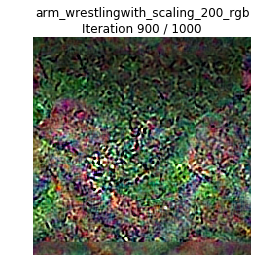

iteration: 900 300.058392048
iteration: 901 300.326731205
iteration: 902 300.611901045
iteration: 903 301.035564184
iteration: 904 301.304549217
iteration: 905 301.596592188
iteration: 906 302.019721031
iteration: 907 302.287773132
iteration: 908 302.554551125
iteration: 909 302.948058128
iteration: 910 303.216442108
iteration: 911 303.514548063
iteration: 912 303.93604517
iteration: 913 304.20661211
iteration: 914 304.484398127
iteration: 915 304.906086206
iteration: 916 305.181369066
iteration: 917 305.474155188
iteration: 918 305.896565199
iteration: 919 306.166470051
iteration: 920 306.455425024
iteration: 921 306.821093082
iteration: 922 307.089557171
iteration: 923 307.383829117
iteration: 924 307.784546137


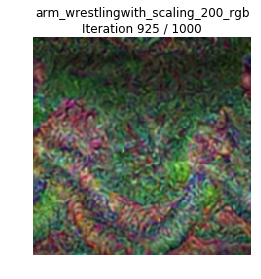

iteration: 925 308.153595209
iteration: 926 308.446412086
iteration: 927 308.871104002
iteration: 928 309.138316154
iteration: 929 309.402751207
iteration: 930 309.787909031
iteration: 931 310.064895153
iteration: 932 310.358171225
iteration: 933 310.740120173
iteration: 934 311.011853218
iteration: 935 311.305736065
iteration: 936 311.731127024
iteration: 937 312.005595207
iteration: 938 312.299730062
iteration: 939 312.702509165
iteration: 940 312.980716228
iteration: 941 313.313732147
iteration: 942 313.719073057
iteration: 943 313.986972094
iteration: 944 314.268627167
iteration: 945 314.744638205
iteration: 946 315.018899202
iteration: 947 315.290454149
iteration: 948 315.691965103
iteration: 949 315.964588165


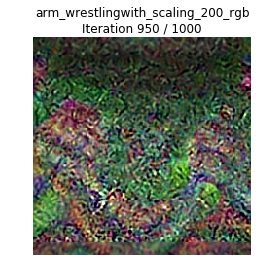

iteration: 950 316.368178129
iteration: 951 316.844559193
iteration: 952 317.123189211
iteration: 953 317.439644098
iteration: 954 317.879661083
iteration: 955 318.155322075
iteration: 956 318.45514822
iteration: 957 318.906625032
iteration: 958 319.184523106
iteration: 959 319.482391119
iteration: 960 319.869799137
iteration: 961 320.141963005
iteration: 962 320.416267157
iteration: 963 320.808067083
iteration: 964 321.076515198
iteration: 965 321.350803137
iteration: 966 321.747255087
iteration: 967 322.032913208
iteration: 968 322.37178421
iteration: 969 322.879032135
iteration: 970 323.163603067
iteration: 971 323.472554207
iteration: 972 323.906355143
iteration: 973 324.18107605
iteration: 974 324.478342056


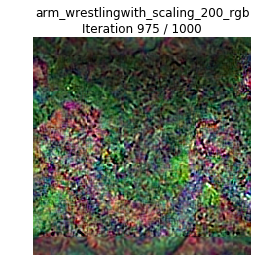

iteration: 975 325.006202221
iteration: 976 325.280610085
iteration: 977 325.551459074
iteration: 978 325.993899107
iteration: 979 326.276144028
iteration: 980 326.580496073
iteration: 981 327.007415056
iteration: 982 327.288389206
iteration: 983 327.614744186
iteration: 984 328.007283211
iteration: 985 328.279216051
iteration: 986 328.557985067
iteration: 987 328.963387012
iteration: 988 329.237791061
iteration: 989 329.526116133
iteration: 990 329.931715012
iteration: 991 330.202984095
iteration: 992 330.472553015
iteration: 993 330.880049229
iteration: 994 331.165594101
iteration: 995 331.511834145
iteration: 996 332.004902124
iteration: 997 332.286528111
iteration: 998 332.589434147
iteration: 999 333.017907143
file_name experiments_rgb/arm_wrestlingwith_scaling_200/arm_wrestlingwith_scaling_200_rgb{}.png


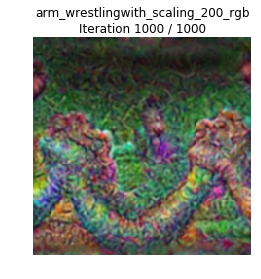

In [7]:
"""
Run RGB visualization only
Make sure graph is built in previous cell before running this cell
"""
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # this line may vary depending on hardware
print(model_logits)
print(rgb_input)
# 279: 'rock scissors paper' 345: 'sword fighting' 277: 'robot dancing' 
# 185: 'making a sandwich', 110: 'eating cake', 320: 'sniffing'
to_visualize = [279, 345, 277, 185, 110, 320]
target = 6 # change this to the desired class 
print(kinetics_classes[target])
action_name = kinetics_classes[target].replace(" ", "_")
with tf.device("/gpu:0"):
    with tf.Session() as sess:
        rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb_imagenet'])
        # number of frames must be >= 9 or else kernel crashes
        rgb_visual_gif = create_class_visualization(sess, rgb_input, flow_input, target, rgb_logits, action_name+"with_scaling_200", 
                                   stream_type='rgb', scale_every=200)

The cell below is used to generate all Optical Flow Visualizations. The hyperparameters inputted below were the ones we found to be best, but we were unable to ever create any good Optical Flow results that were interpretable. 

In [1]:
"""
Run FLOW visualization only.
Make sure graph is built in previous cell before running this cell
"""
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # this line may vary depending on hardware
print(model_logits)
print(flow_input)
target = 171
print(kinetics_classes[target])
action_name = kinetics_classes[target].replace(" ", "_")
with tf.device("/gpu:0"):
    with tf.Session() as sess:
        # THIS LINE NEEDS TO BE MOVED
        flow_saver.restore(sess, _CHECKPOINT_PATHS['flow_imagenet'])
        flow_visual_gif = create_class_visualization(sess, rgb_input, flow_input, target, flow_logits, 
                                                     action_name + "test", stream_type='flow', num_frames=25, 
                                                     num_iterations=1000, l2_reg=1e-2, learning_rate=1.5, 
                                                     blur_every=10, max_jitter=32, sigma=.5)

NameError: name 'os' is not defined

In [ ]:
"""
Print all classes
"""
indexes = range(len(kinetics_classes))
class_to_index = dict(zip(kinetics_classes, indexes))
index_to_class = dict(zip(indexes, kinetics_classes))
print(index_to_class)
